In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
import xarray as xr
import matplotlib.pyplot as plt
from scipy import signal
import ghibtools as gh
import pandas as pd
import seaborn as sns
import neurokit2 as nk
from params import *
from bibliotheque import *
import physio
import time
from compute_phase_freq import baseline_power_job, phase_freq_job
from preproc import convert_vhdr_job

In [86]:
run_key = 'P04_baseline'

In [87]:
baseline = baseline_power_job.get(run_key)['baseline']

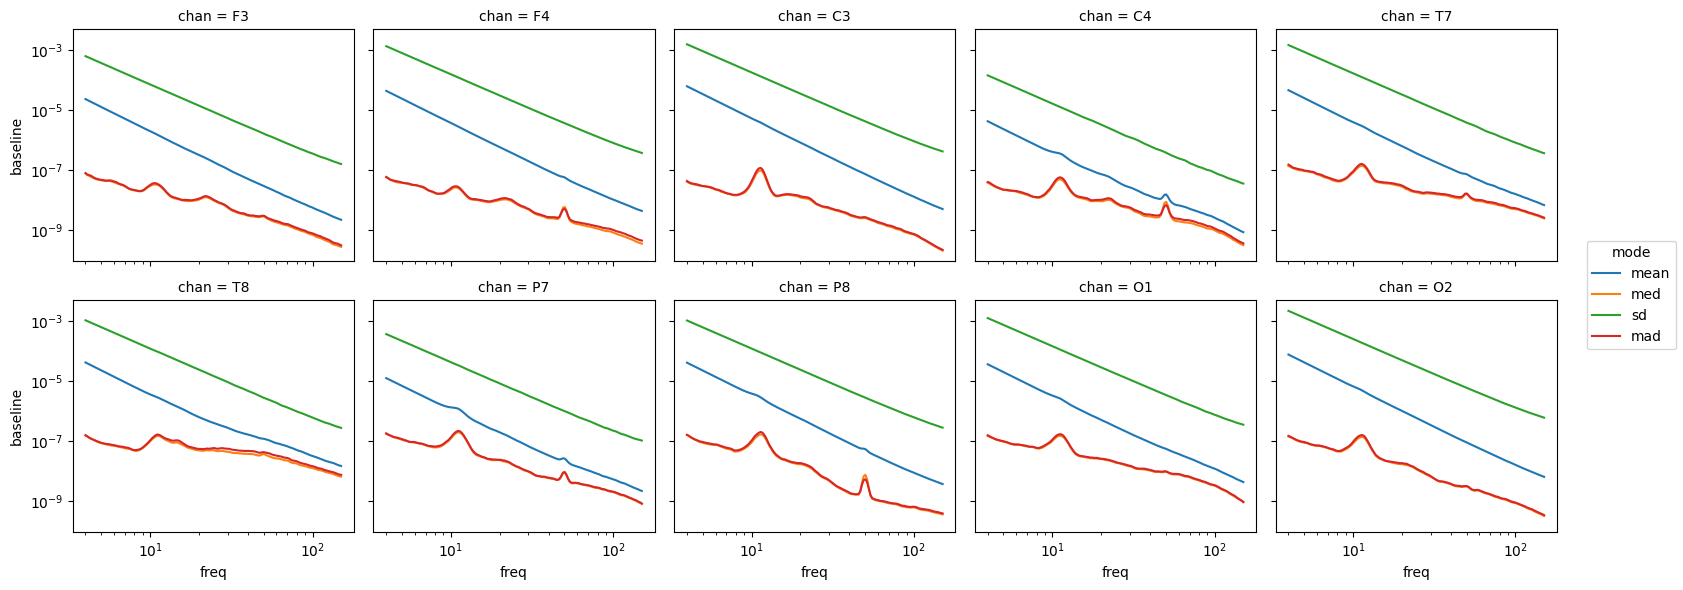

In [89]:
baseline.plot.line(x = 'freq', yscale ='log', xscale = 'log', col = 'chan', col_wrap = 5)

In [75]:
run_key = 'P04_odor'

In [76]:
phase_freq = phase_freq_job.get(run_key)

In [77]:
phase_freq

<xarray.Dataset>
Dimensions:              (phase: 200, freq: 150, chan: 10,
                          compress_cycle_mode: 3, baseline_mode: 2)
Coordinates:
  * phase                (phase) float64 0.0 0.005025 0.01005 ... 0.995 1.0
  * freq                 (freq) float64 4.0 4.098 4.199 ... 142.9 146.4 150.0
  * chan                 (chan) object 'F3' 'F4' 'C3' 'C4' ... 'P8' 'O1' 'O2'
  * compress_cycle_mode  (compress_cycle_mode) object 'mean_cycle' ... 'q75_c...
  * baseline_mode        (baseline_mode) object 'z_score' 'rz_score'
Data variables:
    itpc                 (chan, freq, phase) float64 ...
    power                (baseline_mode, compress_cycle_mode, chan, freq, phase) float64 ...

In [78]:
power = phase_freq['power']

In [91]:
power

<xarray.DataArray 'power' (baseline_mode: 2, compress_cycle_mode: 3, chan: 10,
                           freq: 150, phase: 200)>
[1800000 values with dtype=float64]
Coordinates:
  * phase                (phase) float64 0.0 0.005025 0.01005 ... 0.995 1.0
  * freq                 (freq) float64 4.0 4.098 4.199 ... 142.9 146.4 150.0
  * chan                 (chan) object 'F3' 'F4' 'C3' 'C4' ... 'P8' 'O1' 'O2'
  * compress_cycle_mode  (compress_cycle_mode) object 'mean_cycle' ... 'q75_c...
  * baseline_mode        (baseline_mode) object 'z_score' 'rz_score'

In [79]:
itpc = phase_freq['itpc']

In [90]:
itpc

<xarray.DataArray 'itpc' (chan: 10, freq: 150, phase: 200)>
[300000 values with dtype=float64]
Coordinates:
  * phase    (phase) float64 0.0 0.005025 0.01005 0.01508 ... 0.9899 0.995 1.0
  * freq     (freq) float64 4.0 4.098 4.199 4.303 ... 139.4 142.9 146.4 150.0
  * chan     (chan) object 'F3' 'F4' 'C3' 'C4' 'T7' 'T8' 'P7' 'P8' 'O1' 'O2'

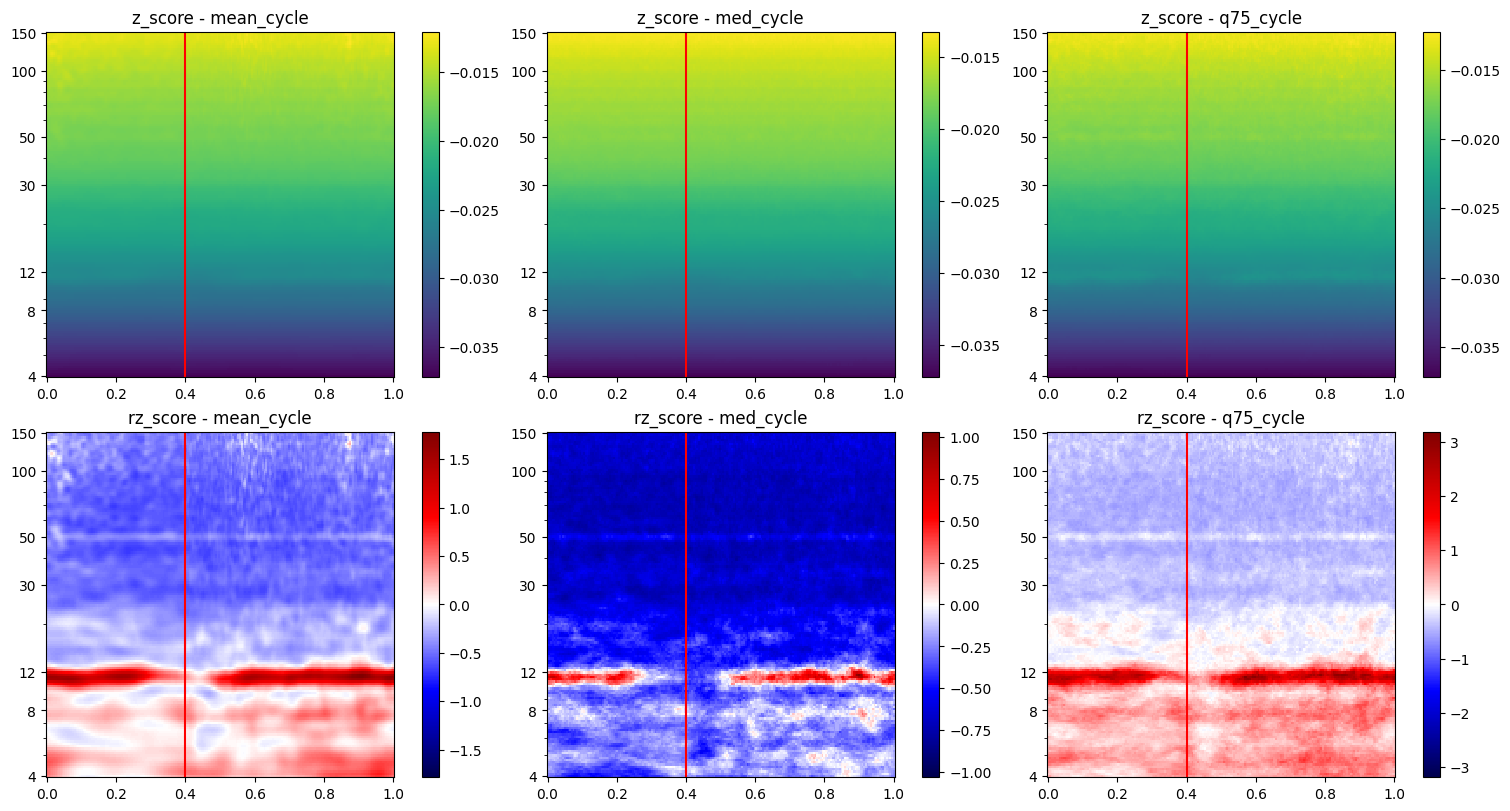

In [80]:
delta = 0.

nrows = power.coords['baseline_mode'].size
ncols = power.coords['compress_cycle_mode'].size

freq_ticks = [4 , 8 , 12 , 30 , 50 , 100 , 150]

fig, axs = plt.subplots(nrows, ncols , figsize = (15,8), constrained_layout = True)

for r,  baseline_mode in enumerate(power.coords['baseline_mode'].values):
    for c, compress_cycle_mode in enumerate(power.coords['compress_cycle_mode'].values):
        ax = axs[r,c]
        
        tf = power.loc[baseline_mode,compress_cycle_mode, 'F3', :, :].values
        
        vmin = np.quantile(tf, q = delta)
        vmax = np.quantile(tf, q = 1 - delta)
        
        
        if vmax > 0 and vmin < 0:
            vmin = vmin if abs(vmin) > abs(vmax) else -vmax 
            vmax = vmax if abs(vmax) > abs(vmin) else abs(vmin)
            cmap = 'seismic'
        else:
            vmin = vmin
            vmax = vmax
            cmap = 'viridis'
        
        im = ax.pcolormesh(
            power.coords['phase'].values,
            power.coords['freq'].values,
            tf,
            cmap = cmap,
            vmin=vmin,
            vmax=vmax)
        
        ax.set_yscale('log')
        ax.set_yticks(freq_ticks, labels = freq_ticks)
        ax.set_title(f'{baseline_mode} - {compress_cycle_mode}')
        ax.axvline(0.4, color ='r')
        
        fig.colorbar(im ,ax=ax)
        
    

convert_vhdr is processing ('P15_baseline',)
convert_vhdr is processing ('P15_music',)
convert_vhdr is processing ('P15_odor',)


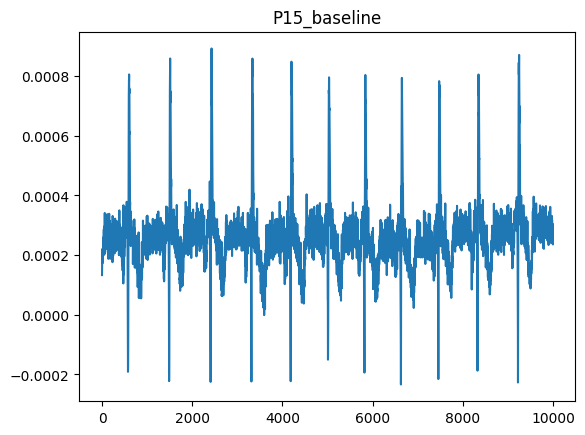

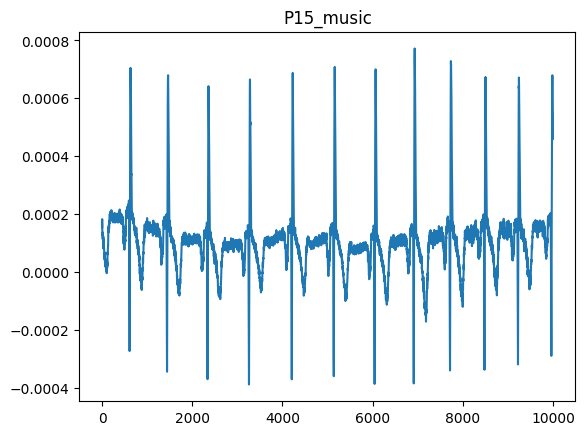

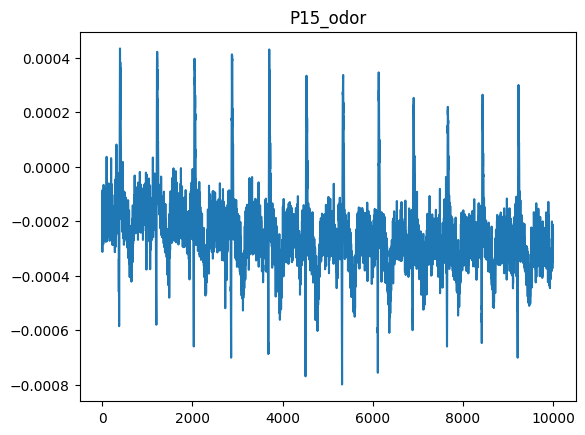

In [5]:

# for run_key in run_keys:
sub = 'P15'
for run_key in [f'{sub}_baseline',f'{sub}_music',f'{sub}_odor']:
    ecg = convert_vhdr_job.get(run_key)['raw'].loc['ECG',0:10].values
    fig, ax = plt.subplots()
    ax.plot(ecg)
    ax.set_title(run_key)
    

In [3]:
run_key = 'P01_baseline'

da = convert_vhdr_job.get(run_key)['raw']
srate = da.attrs['srate']

In [7]:
eda = da.loc['GSR',:].values

In [19]:
f, Pxx = gh.spectre(eda, srate, 0.01, n_cycles = 3, verbose = True)

nperseg : 300000
sig size : 621300
total cycles lowest freq : 6
nwindows : 4


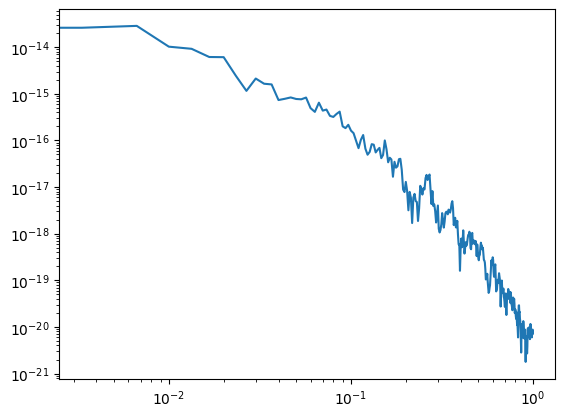

In [21]:
mask = f < 1
fig, ax = plt.subplots()
ax.loglog(f[mask], Pxx[mask])

In [25]:
import neurokit2 as nk 

In [23]:
eda_clean = gh.iirfilt(eda, srate, lowcut=  None, highcut = 3, ftype = 'butter', order = 4) 

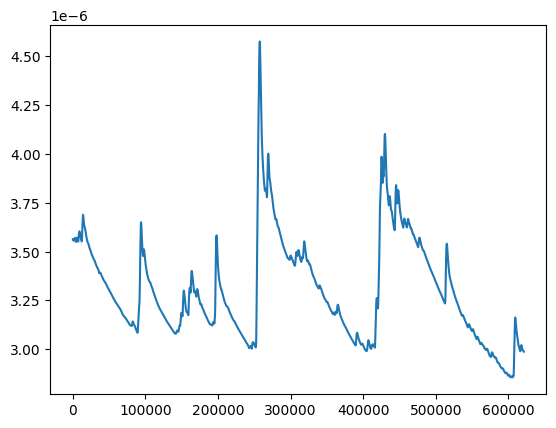

In [24]:
fig ,ax = plt.subplots()
ax.plot(eda_clean)

In [26]:
signals, info = nk.eda_process(eda, srate)

In [126]:
info

{'SCR_Onsets': array([ 12192,  91431, 150962, 162088, 195051, 252460, 267263, 316892,
        404470, 416255, 424032, 428247, 435135, 443333, 460163, 512911,
        607182]),
 'SCR_Peaks': array([ 14003,  93818, 152865, 163653, 197782, 257236, 269288, 318805,
        407160, 417836, 425088, 429954, 436819, 445291, 461893, 515057,
        609375]),
 'SCR_Height': array([7.94501433e-08, 2.38508272e-07, 9.04620166e-08, 8.58053418e-08,
        2.40223125e-07, 5.70795563e-07, 1.26135464e-07, 6.22444935e-08,
        5.08979864e-08, 1.66541554e-08, 2.14066688e-07, 1.77904242e-07,
        3.17392043e-09, 1.16513954e-07, 3.06117673e-08, 1.62103844e-07,
        1.52744267e-07]),
 'SCR_Amplitude': array([1.31799798e-07, 3.29276520e-07, 1.10011184e-07, 9.64556903e-08,
        3.67311365e-07, 9.93274094e-07, 2.55151528e-07, 8.61782292e-08,
        6.07858766e-08, 1.29439249e-07, 9.92381462e-08, 1.96012037e-07,
        8.52745914e-08, 2.19494542e-07, 4.98447663e-08, 2.70077187e-07,
        2.517617

In [27]:
signals

,EDA_Raw,EDA_Clean,EDA_Tonic,EDA_Phasic,SCR_Onsets,SCR_Peaks,SCR_Height,SCR_Amplitude,SCR_RiseTime,SCR_Recovery,SCR_RecoveryTime
0,0.000004,0.000004,0.000004,2.761132e-09,0,0,0.0,0.0,0.0,0,0.0
1,0.000004,0.000004,0.000004,2.766584e-09,0,0,0.0,0.0,0.0,0,0.0
2,0.000004,0.000004,0.000004,2.771969e-09,0,0,0.0,0.0,0.0,0,0.0
3,0.000004,0.000004,0.000004,2.777288e-09,0,0,0.0,0.0,0.0,0,0.0
4,0.000004,0.000004,0.000004,2.782536e-09,0,0,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
621295,0.000003,0.000003,0.000003,-1.257086e-10,0,0,0.0,0.0,0.0,0,0.0
621296,0.000003,0.000003,0.000003,-1.160411e-10,0,0,0.0,0.0,0.0,0,0.0
621297,0.000003,0.000003,0.000003,-1.063718e-10,0,0,0.0,0.0,0.0,0,0.0
621298,0.000003,0.000003,0.000003,-9.670084e-11,0,0,0.0,0.0,0.0,0,0.0


In [42]:
%matplotlib widget

Text(0.5, 1.0, '17')

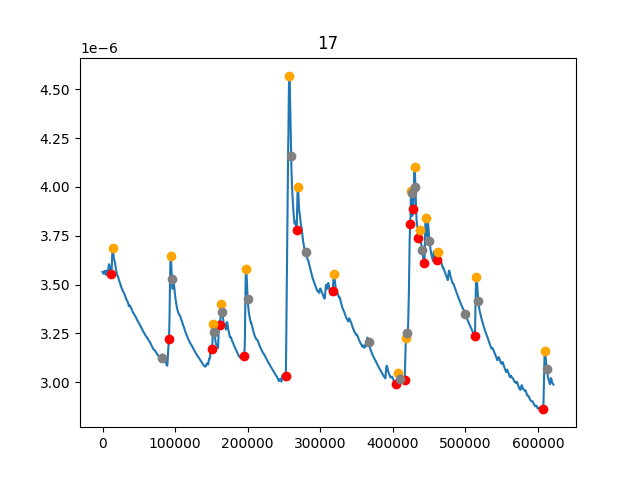

In [125]:
fig ,ax = plt.subplots()
sig = signals['EDA_Clean']
# sig = signals['EDA_Phasic']
ax.plot(sig)
ax.plot(sig[signals['SCR_Onsets'] == 1] ,'o', color = 'r')
ax.plot(sig[signals['SCR_Peaks'] == 1] ,'o', color = 'orange')
ax.plot(sig[signals['SCR_Recovery'] == 1] ,'o', color = 'grey')
N = sum(signals['SCR_Peaks'] == 1)
ax.set_title(N)

In [95]:
info

{'SCR_Onsets': array([ 12192,  91431, 150962, 162088, 195051, 252460, 267263, 316892,
        404470, 416255, 424032, 428247, 435135, 443333, 460163, 512911,
        607182]),
 'SCR_Peaks': array([ 14003,  93818, 152865, 163653, 197782, 257236, 269288, 318805,
        407160, 417836, 425088, 429954, 436819, 445291, 461893, 515057,
        609375]),
 'SCR_Height': array([7.94501433e-08, 2.38508272e-07, 9.04620166e-08, 8.58053418e-08,
        2.40223125e-07, 5.70795563e-07, 1.26135464e-07, 6.22444935e-08,
        5.08979864e-08, 1.66541554e-08, 2.14066688e-07, 1.77904242e-07,
        3.17392043e-09, 1.16513954e-07, 3.06117673e-08, 1.62103844e-07,
        1.52744267e-07]),
 'SCR_Amplitude': array([1.31799798e-07, 3.29276520e-07, 1.10011184e-07, 9.64556903e-08,
        3.67311365e-07, 9.93274094e-07, 2.55151528e-07, 8.61782292e-08,
        6.07858766e-08, 1.29439249e-07, 9.92381462e-08, 1.96012037e-07,
        8.52745914e-08, 2.19494542e-07, 4.98447663e-08, 2.70077187e-07,
        2.517617

In [55]:
physio_peaks = physio.detect_peak(sig.values, srate, exclude_sweep_ms = 1000)

In [56]:
physio_peaks

array([ 14003,  93818, 152865, 163653, 197782, 257236, 269288, 318805,
       425088, 429954, 445291, 448312, 515057, 609375])

Text(0.5, 1.0, '14')

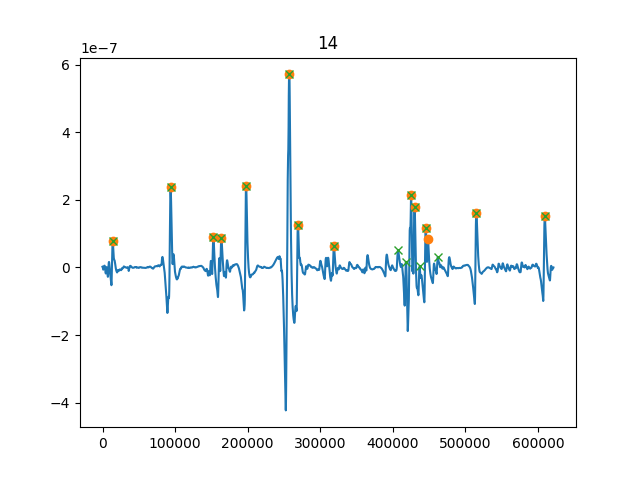

In [57]:
fig ,ax = plt.subplots()
# ax.plot(signals['EDA_Clean'])
sig = signals['EDA_Phasic']
ax.plot(sig)
ax.plot(sig[physio_peaks], 'o')
ax.plot(sig[signals['SCR_Peaks'] == 1], 'x')
N = physio_peaks.size
ax.set_title(N)

In [98]:
trous = physio.detect_peak(-phasic, srate, thresh = 2, exclude_sweep_ms = 1000)

In [110]:
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [118]:
[find_nearest(trous, pic) for pic in pics]

[81180,
 89155,
 89155,
 192192,
 194960,
 252335,
 252335,
 420442,
 420442,
 443314,
 443314,
 512755,
 607128]

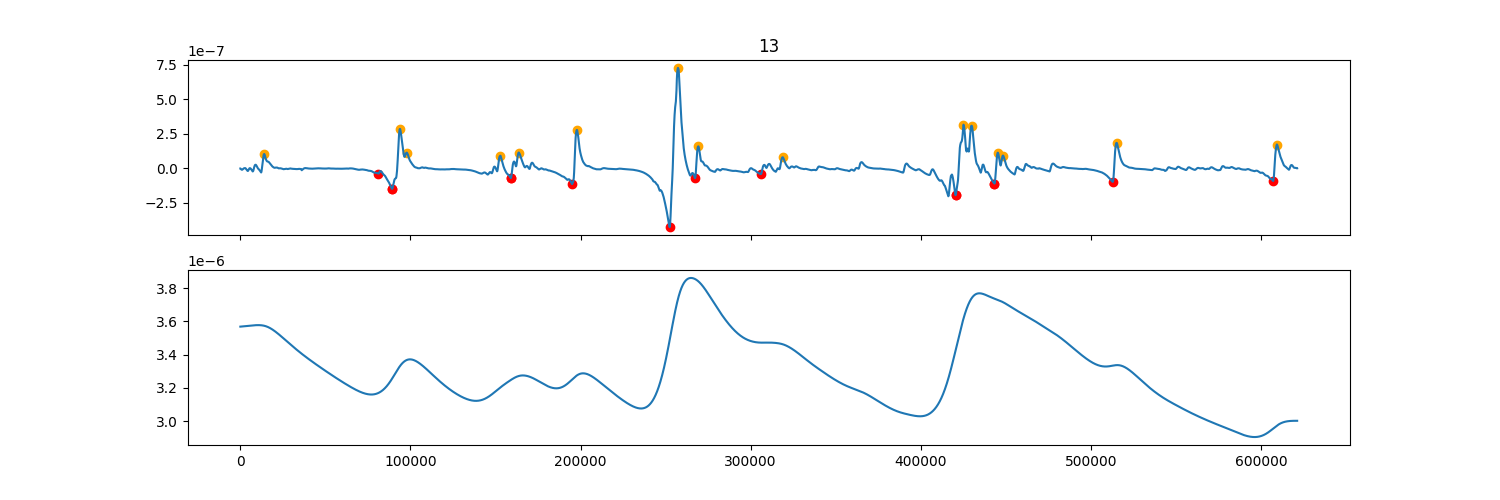

In [ ]:
fig ,axs = plt.subplots(nrows = 2, sharex= True ,figsize = (15,5))
cutoff = 0.03
ftype = 'bessel'

tonic, phasic = gh.iirfilt(eda_clean, srate, highcut = cutoff, order = 2, ftype = ftype), gh.iirfilt(eda_clean, srate, lowcut = cutoff, order = 1, ftype = ftype)
pics = physio.detect_peak(phasic, srate, thresh = 4, exclude_sweep_ms = 1000)
trous = physio.detect_peak(-phasic, srate, thresh = 2, exclude_sweep_ms = 500)
trous = [find_nearest(trous, pic) for pic in pics]

ax = axs[0]
ax.plot(phasic)
ax.scatter(x = trous, y = phasic[trous], color = 'red')
ax.scatter(x = pics, y = phasic[pics], color = 'orange')
ax.set_title(physio_peaks.size)

ax = axs[1]
ax.plot(tonic)
plt.show()

In [135]:
def get_eda_metrics(eda_signal, srate, show = False):
    df, info = nk.eda_process(eda_signal, sampling_rate=srate, method='neurokit')
    tonic = df['EDA_Tonic'].mean()
    info_df = pd.DataFrame.from_dict(info, orient = 'columns')
    n_scr = info_df.shape[0]
    metrics = pd.DataFrame.from_dict(info, orient = 'columns').drop(columns = ['sampling_rate','SCR_Onsets','SCR_Peaks','SCR_Recovery']).mean().to_frame().T
    metrics.insert(0, 'N_SCR', n_scr)
    metrics.insert(0, 'Tonic', tonic)

    if show:
        plt.figure()
        nk.eda_plot(df)
        plt.show()

    return metrics

In [136]:
metrics = get_eda_metrics(eda, srate)

In [137]:
metrics

,Tonic,N_SCR,SCR_Height,SCR_Amplitude,SCR_RiseTime,SCR_RecoveryTime
0,0.000003,17,1.422527e-07,2.194933e-07,2.109176,11.292706


In [10]:
da_resp = None
rows = []
for run_key in run_keys:
    participant, session = run_key.split('_')
    resp = convert_vhdr_job.get(run_key)['raw'].loc['RespiNasale',:600].values
    f, Pxx = gh.spectre(resp, 1000, 0.08)
    if da_resp is None:
        da_resp = init_nan_da({'participant':subject_keys, 'session':session_keys, 'freq':f})
    da_resp.loc[participant, session, : ] = Pxx
    rows.append([participant, 
                 session, 
                 float(da_resp.loc[participant, session , 0.05 : 0.6].max()), 
                 float(da_resp.loc[participant, session , 0.05 : 0.6].idxmax())])

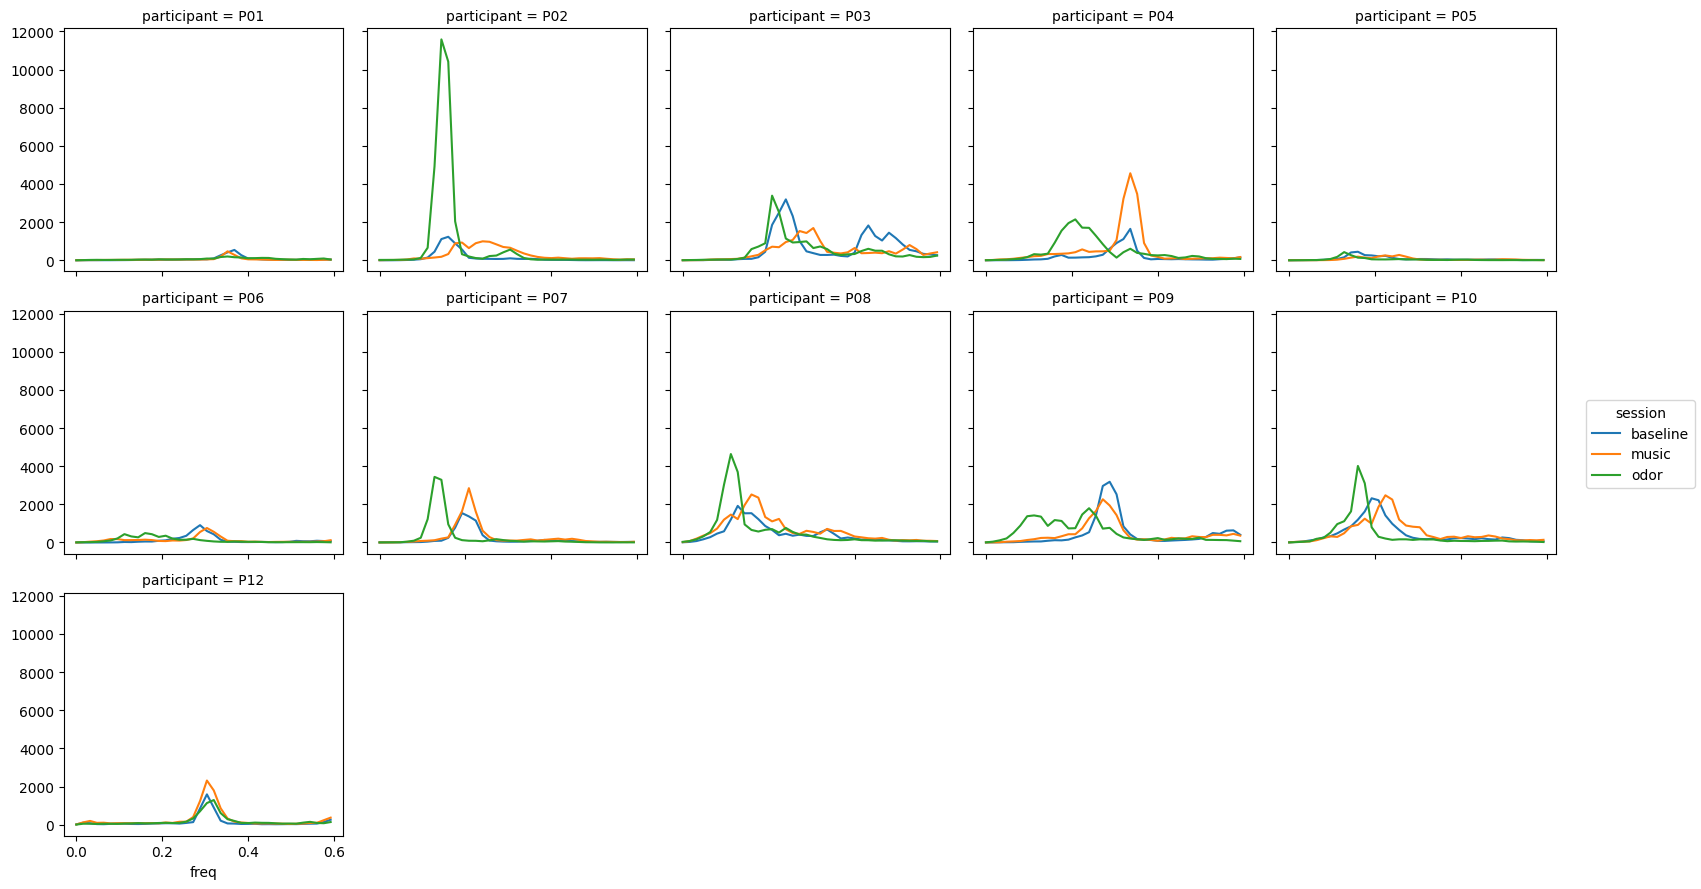

In [6]:
da_resp.sel(freq = slice(0, 0.6)).plot.line(x='freq', hue = 'session', col = 'participant', col_wrap = 5)

In [11]:
df_resp = pd.DataFrame(rows, columns = ['participant','session','max','fmax'])

In [12]:
df_resp

,participant,session,max,fmax
0,P01,baseline,543.145586,0.368
1,P01,music,469.642655,0.352
2,P01,odor,199.781456,0.352
3,P02,baseline,1232.473493,0.160
4,P02,music,995.023627,0.240
5,P02,odor,11580.681083,0.144
6,P03,baseline,3192.898224,0.240
7,P03,music,1691.260718,0.304
8,P03,odor,3388.047520,0.208
9,P04,baseline,1648.310906,0.336


<AxesSubplot: xlabel='session', ylabel='max'>

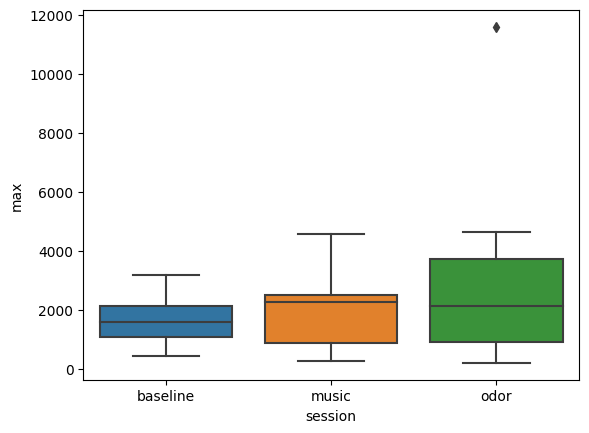

In [13]:
sns.boxplot(data = df_resp, x = 'session', y = 'max')

<AxesSubplot: xlabel='session', ylabel='fmax'>

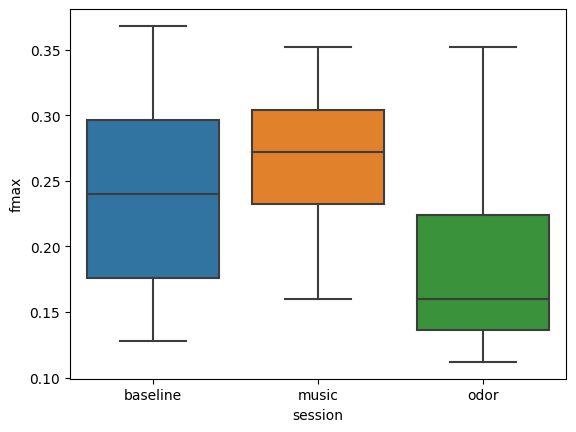

In [14]:
sns.boxplot(data = df_resp, x = 'session', y = 'fmax')